In [26]:
import pandas as pd
import numpy as np
import datetime
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import re,os
import unicodedata
import matplotlib.pyplot as plt
import itertools
import sklearn.metrics as metrics
from sklearn import metrics, feature_selection
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss,accuracy_score,classification_report,accuracy_score,confusion_matrix,recall_score,precision_score,roc_curve
from transformers import Trainer, TrainingArguments, EvalPrediction,DataCollatorWithPadding, Trainer, TrainingArguments, AutoModelForSequenceClassification
from transformers import BertModel, BertConfig, BertTokenizer, DebertaConfig, DebertaModel, DebertaTokenizer,DebertaV2Model, DebertaV2Config,DebertaV2Tokenizer,AutoTokenizer,AutoModel,AutoConfig

from transformers.modeling_outputs import SequenceClassifierOutput
from bs4 import BeautifulSoup

In [2]:
device=torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

In [3]:
#CON BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
# MODEL = BertModel.from_pretrained('bert-base-uncased', config=config)
# CON DEBERTA
# tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
# config = DebertaConfig.from_pretrained("microsoft/deberta-base", output_hidden_states=True, output_attentions=True)
# MODEL = DebertaModel.from_pretrained("microsoft/deberta-base", config=config)

# CON MDEBERTA

tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")
config = AutoConfig.from_pretrained("microsoft/mdeberta-v3-base",output_hidden_states=True, output_attentions=True)
MODEL = AutoModel.from_pretrained("microsoft/mdeberta-v3-base", config=config)

# MODEL_TYPE = 'bert'
MODEL_TYPE = 'deberta'
# MODEL_TYPE = 'bert'
MODEL_TYPE = 'deberta'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_pre

In [4]:
dataTrainer = pd.read_json("C:/DataSets/release/pan23-multi-author-analysis-dataset1/pan23-multi-author-analysis-dataset1-train/mdebertaTokenizer.json")
dataEvaluation = pd.read_json("C:/DataSets/release/pan23-multi-author-analysis-dataset1/pan23-multi-author-analysis-dataset1-validation/mdebertaTokenizer.json")

In [7]:
dataTrainer=dataTrainer.iloc[:5,:]

In [8]:
dataEvaluation=dataEvaluation.iloc[:3,:]

In [10]:
class MyDataset(Dataset):             # define una nueva clase MyDataset que hereda de Dataset
    def __init__(self, dataframe):    # define el constructor  "__init__"  que toma un solo argumento dataframe
        #print(dataframe)
        self.len = len(dataframe)   # calcula la longitud de la entrada dataframe usando la funcion "len" y la almacena como una variable de instancia "self.len"
        self.data = dataframe       # se asigna la entrada dataframe a una variable de instancia "self.data"


    def __getitem__(self, index):   # define el método "__getitem__" que toma un solo argumento index
        ''' el metodo __getitem__ devuelve un diccionario que contiene cuatro claves: 'input_ids', 'attention_mask', 'labels'y 'added_features' '''

        input_ids = torch.tensor(self.data.text_vec.iloc[index]).cpu() # almacena las características de los datos de "text_vec" ​​que se han convertido en un vector de longitud fija.
        #attention_mask = torch.ones([input_ids.size(0)]).cpu()  # attention_mask almacena los elementos de entrada que se debe prestar atención y cuáles se deben ignorar
        #
        mask = torch.ones(input_ids.shape,dtype=int)#Crear un tensor con el mismo tamaño que input_ids lleno de unos:
        pad_positions = (input_ids == 0)#Identificar las posiciones en input_ids que contienen el token especial [PAD]
        mask[pad_positions] = 0 #Actualizar las posiciones correspondientes en mask a cero:
        attention_mask = mask #Actualizar las posiciones correspondientes en mask a cero:
        #
        label = self.data.same.iloc[index] # almacena un valor escalar que representa la etiqueta de salida para la puntuación de complejidad
        targets = torch.tensor([1 - label, label])  #ojo probar ESTO ES NUEVO
        return {
            'input_ids': input_ids,               # devuelve las características de entrada para el punto de datos
            'attention_mask': attention_mask,     # devuelve la máscara de atención para el punto de datos
            'labels': targets                    # devuelve un valor escalar que representa la puntuación de complejidad
        }

    def __len__(self):
        return self.len   # devuelve la longitud del conjunto de datos personalizado

In [11]:
train_set, eval_dataset = MyDataset(dataTrainer), MyDataset(dataEvaluation)

In [12]:
train_set.len, eval_dataset.len

(5, 3)

In [13]:
train_set

In [154]:

class StackedCLSModel(nn.Module):
      def __init__(self, model=MODEL, model_type=MODEL_TYPE):
        super(StackedCLSModel, self).__init__()
        self.model = MODEL
        self.model_type = MODEL_TYPE
        self.Fusion = nn.Parameter(torch.zeros(12, 1))
        self.dropout = nn.Dropout(0.2)
        self.funActivacion = nn.ReLU()
        self.lin1 = nn.Linear(768, 128)
        self.lin2 = nn.Linear(128, 2)
        self.loss_func = nn.CrossEntropyLoss()
        self.init = 0
      def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        if self.model_type == "bert":
          cls_tensors = torch.stack([outputs[2][n][:, 0, :] for n in range(1, 13)])
        elif self.model_type == "deberta":
          cls_tensors = torch.stack([outputs[1][n][:, 0, :] for n in range(1, 13)])
        t_cls_tensors = cls_tensors.transpose(1, 0)
        t_cls_tensors_mean = torch.mean(t_cls_tensors, dim=1)  # Reducción de la dimensión 12 a 2
        x = self.lin1(t_cls_tensors_mean)
        x = self.dropout(x)
        x = self.funActivacion(x)
        logit = self.lin2(x)
        loss = None
        if labels is not None:
          loss = self.loss_func(logit, labels.float())
          loss = loss.mean()
        return SequenceClassifierOutput(loss=loss, logits=logit)
      def predict(self, input_ids, attention_mask):
          logits = self.forward(input_ids, attention_mask, labels=None)
          predicciones = logits.logits.argmax(dim=1)
          return predicciones.tolist()

      


In [17]:
def c_at_1(train_data, test_data, threshold=0.5):
      n = float(len(test_data))
      nc, nu = 0.0, 0.0

      for gt_score, pred_score in zip(train_data, test_data):
        if pred_score == 0.5:
          nu += 1
        elif (pred_score > 0.5) == (gt_score > 0.5):
          nc += 1.0

      return (1 / n) * (nc + (nu * nc / n))

def binarize(y, threshold=0.5, triple_valued=False):
    y = np.array(y)
    y = np.ma.fix_invalid(y, fill_value=threshold)
    if triple_valued:
        y[y > threshold] = 1
    else:
        y[y >= threshold] = 1
    y[y < threshold] = 0
    return y

def f_05_u_score(train_data, test_data, pos_label=1, threshold=0.5):

      test_data = binarize(test_data)

      n_tp = 0
      n_fn = 0
      n_fp = 0
      n_u = 0

      for i, pred in enumerate(test_data):
        if pred == threshold:
          n_u += 1
        elif pred == pos_label and pred == train_data[i]:
          n_tp += 1
        elif pred == pos_label and pred != train_data[i]:
          n_fp += 1
        elif train_data[i] == pos_label and pred != train_data[i]:
          n_fn += 1

      return (1.25 * n_tp) / (1.25 * n_tp + 0.25 * (n_fn + n_u) + n_fp)

def brier_score(train_data, test_data):
      try:
        return 1 - brier_score_loss(train_data, test_data)
      except ValueError:
        return 0.0

def auc_score(train_data, test_data):
    try:
        return roc_auc_score(train_data, test_data)
    except ValueError:
        return 0.0


In [18]:
def compute_metrics(p: EvalPrediction): # calcula diversas métricas de evaluación
  preds = np.argmax(p.predictions,axis=-1)
  preds = np.squeeze(preds)
  labels = np.argmax(p.label_ids,axis=-1)
  labels = np.squeeze(labels)
  precision = precision_score(labels, preds, average='micro')
  precision_macro = precision_score(labels, preds, average='macro')
  auc = auc_score(labels, preds)
  #mse = metrics.mean_squared_error(labels, preds)# Se toma el primer indice del label
  #print("SIZES::::",labels.shape, preds.shape)


  return {
          'auc': auc,
          'c@1': c_at_1(labels, preds),
          'f_05_u': f_05_u_score(labels, preds),
          'F1': f1_score(labels, preds, average = 'micro'),
          'brier': brier_score(labels, preds),
          'precision micro': precision,
          'precision macro': precision_macro
          }

In [95]:
# Definir bien los argumentos
args = TrainingArguments(
    output_dir='output',  # Ruta del directorio de salida donde se guardarán los resultados del entrenamiento
    evaluation_strategy='epoch',  # Evaluación del modelo al final de cada época
    num_train_epochs=7,  # Número total de épocas de entrenamiento
    per_device_train_batch_size=16,  # Tamaño del lote de entrenamiento por dispositivo. Ajustar según la memoria GPU disponible
    per_device_eval_batch_size=16,  # Tamaño del lote de evaluación por dispositivo. Ajustar según la memoria GPU disponible
    learning_rate=5e-5,  # Tasa de aprendizaje utilizada en el entrenamiento
    overwrite_output_dir=True,  # Sobrescribir el directorio de salida si ya existe
    remove_unused_columns=False,  # No eliminar columnas no utilizadas del conjunto de datos
    logging_dir='logs',  # Ruta del directorio donde se guardarán los archivos de registro del entrenamiento
    logging_steps=10,  # Número de pasos después de los cuales se realizará el registro
    save_strategy='epoch',  # Estrategia de guardado del modelo: al final de cada época
    save_total_limit=10,  # Límite total de modelos guardados
    load_best_model_at_end=True,  # Cargar el mejor modelo al final del entrenamiento
    warmup_steps=10,  # Número de pasos de calentamiento antes de ajustar la tasa de aprendizaje
    weight_decay=0.03,  # Factor de decaimiento de peso para la regularización L2
    adam_epsilon=1e-8,  # Epsilon para el optimizador Adam, utilizado para la estabilidad numérica
    adam_beta1=0.5,  # Coeficiente beta1 para el optimizador Adam
    adam_beta2=0.5,  # Coeficiente beta2 para el optimizador Adam
    lr_scheduler_type='cosine',  # Tipo de programador de tasa de aprendizaje: programador coseno curva de aprendizaje  entre el eje x
    gradient_accumulation_steps=1,  # Número de pasos de acumulación de gradiente antes de realizar una actualización de parámetros
    max_grad_norm=5.0,  # Valor máximo de la norma del gradiente para evitar explosiones de gradiente
    save_steps=10  # Número de pasos después de los cuales se guarda el modelo
    )


In [163]:
model = StackedCLSModel(trainer.model, MODEL_TYPE)

In [164]:
trainer = Trainer(
   model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [98]:
result=None
result=trainer.train()

c:\Python311\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 14%|█▍        | 1/7 [00:26<02:08, 21.46s/it]

{'eval_loss': 0.6131136417388916, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 4.7587, 'eval_samples_per_second': 0.63, 'eval_steps_per_second': 0.21, 'epoch': 1.0}


 29%|██▊       | 2/7 [01:00<02:22, 28.58s/it]

{'eval_loss': 0.6127775311470032, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 4.9825, 'eval_samples_per_second': 0.602, 'eval_steps_per_second': 0.201, 'epoch': 2.0}


 43%|████▎     | 3/7 [02:21<03:32, 53.14s/it]

{'eval_loss': 0.6123310327529907, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 4.1676, 'eval_samples_per_second': 0.72, 'eval_steps_per_second': 0.24, 'epoch': 3.0}


 57%|█████▋    | 4/7 [04:01<03:34, 71.50s/it]

{'eval_loss': 0.611556351184845, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 4.1035, 'eval_samples_per_second': 0.731, 'eval_steps_per_second': 0.244, 'epoch': 4.0}


 71%|███████▏  | 5/7 [05:40<02:43, 81.64s/it]

{'eval_loss': 0.6103667616844177, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 4.1221, 'eval_samples_per_second': 0.728, 'eval_steps_per_second': 0.243, 'epoch': 5.0}


 86%|████████▌ | 6/7 [07:28<01:30, 90.61s/it]

{'eval_loss': 0.6087602376937866, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 3.9709, 'eval_samples_per_second': 0.755, 'eval_steps_per_second': 0.252, 'epoch': 6.0}


100%|██████████| 7/7 [09:13<00:00, 95.30s/it]

{'eval_loss': 0.6061851978302002, 'eval_auc': 0.0, 'eval_c@1': 1.0, 'eval_f_05_u': 1.0, 'eval_F1': 1.0, 'eval_brier': 1.0, 'eval_precision micro': 1.0, 'eval_precision macro': 1.0, 'eval_runtime': 3.9325, 'eval_samples_per_second': 0.763, 'eval_steps_per_second': 0.254, 'epoch': 7.0}


100%|██████████| 7/7 [11:43<00:00, 100.46s/it]

{'train_runtime': 703.2718, 'train_samples_per_second': 0.05, 'train_steps_per_second': 0.01, 'train_loss': 0.683619567326137, 'epoch': 7.0}


In [23]:


def group_by_property(metrics):
    properties = set()
    for metric in metrics:
        for property in metric:
            properties.add(property)
    grouped_metrics = {}
    for property in properties:
        grouped_metrics[property] = [metric for metric in metrics if property in metric]
    return grouped_metrics
def agrupar_propiedades(lista):
    resultado = {}
    for diccionario in lista:
        for propiedad, valor in diccionario.items():
            # Reemplazar espacios y caracteres especiales en la propiedad con guiones bajos
            propiedad = propiedad.replace(' ', '_').replace('-', '_')
            if propiedad not in resultado:
                resultado[propiedad] = []
            resultado[propiedad].append(valor)
    return resultado

def _getvalores(data,key):{
  [metric[key] for metric in data if key in data]
}



def normalizar_propiedades(lista):
    for diccionario in lista:
        for propiedad in list(diccionario.keys()):
            propiedad_normalizada = propiedad.replace(" ", "_").replace("-", "_").replace(".", "_").replace(":", "_").replace("/", "_")
            if propiedad != propiedad_normalizada:
                diccionario[propiedad_normalizada] = diccionario.pop(propiedad)
    return lista


In [99]:
def generarGrafico(metrics,numero=2):
    metricas2 = agrupar_propiedades(metrics)
    fecha_hora = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # Configurar el gráfico
    plt.figure(figsize=(10, 8))
    plt.title('Métricas de entrenamiento por época')
    plt.xlabel('Época')
    plt.ylabel('Valor de la métrica')
    plt.ylim(0, 1.5)

    # Graficar cada métrica con longitud distinta a 7
    for name, valores in metricas2.items():
        if len(valores) == numero:  # Verificar si la longitud es igual a 7
            plt.plot(range(len(valores)), valores, label=name,marker='o')

    # Agregar leyenda y mostrar gráfico
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Establecer valores y etiquetas en el eje y con todos los decimales
    plt.yticks([i / 10 for i in range(15)])

    # Agregar fecha y hora al pie de la gráfica
    plt.figtext(0.99, 0.01, fecha_hora, ha='right', va='bottom')

    # Guardar el gráfico en la ubicación especificada
    plt.savefig(os.path.join('Graficos', 'grafico.png'))
    plt.show()


In [101]:
metrics=trainer.state.log_history


In [102]:
metrics=normalizar_propiedades(metrics)


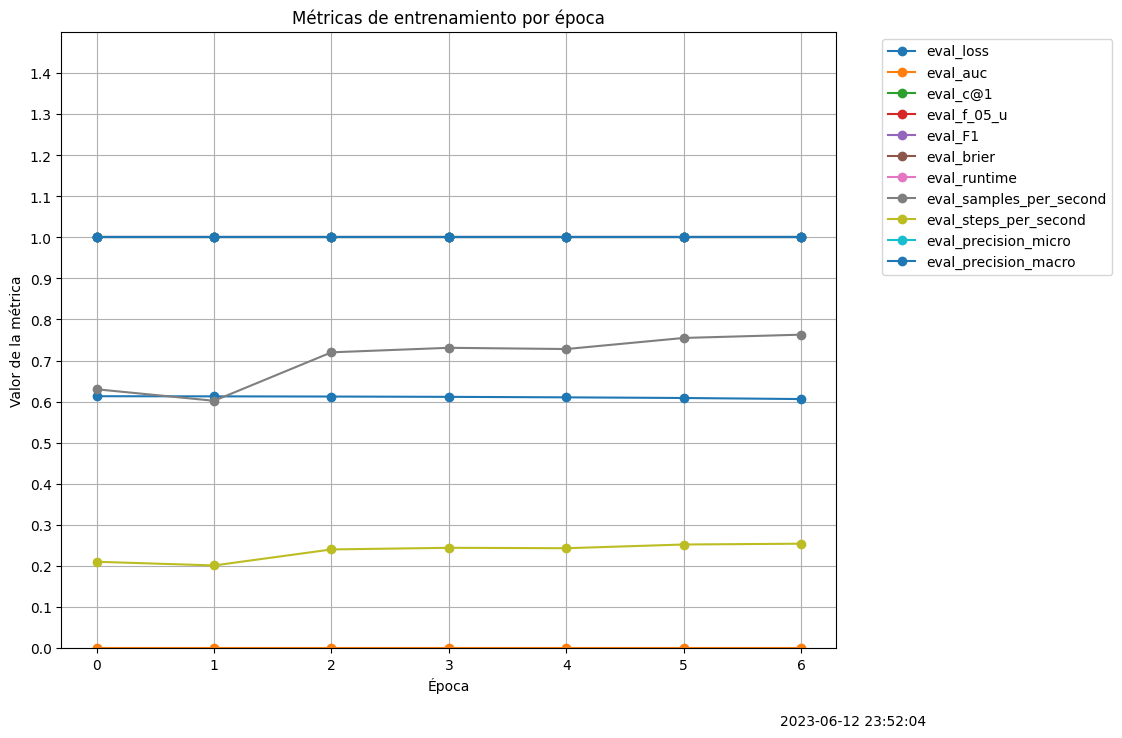

In [104]:
generarGrafico(metrics,args.num_train_epochs)

In [156]:
torch.save(model, 'best_model.pth')


In [157]:
modelo_cargado = torch.load('best_model.pth')


In [ ]:
modelo_cargado

In [152]:
train_input_ids = [train_set[i]['input_ids'] for i in range(len(train_set))]
train_attention_mask = [train_set[i]['attention_mask'] for i in range(len(train_set))]


In [158]:
train_input_ids_tensor = torch.stack(train_input_ids)  # Convertir la lista en un tensor
train_attention_mask_tensor = torch.stack(train_attention_mask)  # Convertir la lista en un tensor

# Realizar las predicciones con el modelo cargado
predicciones = modelo_cargado.predict(train_input_ids_tensor, train_attention_mask_tensor)


In [165]:
predicciones = trainer.predict(train_set)


  0%|          | 0/1 [00:00<?, ?it/s]c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1/1 [00:00<00:00, 66.42it/s]


In [166]:
prediciones

PredictionOutput(predictions=array([[-0.06403185,  0.12055501],
       [-0.06359295,  0.10869522],
       [-0.07245757,  0.1143637 ],
       [-0.07061363,  0.11275133],
       [-0.06689371,  0.10885499]], dtype=float32), label_ids=array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0]], dtype=int64), metrics={'test_loss': 0.6765472292900085, 'test_auc': 0.5, 'test_c@1': 0.6000000000000001, 'test_f_05_u': 0.6521739130434783, 'test_F1': 0.6, 'test_brier': 0.6, 'test_precision micro': 0.6, 'test_precision macro': 0.3, 'test_runtime': 6.7526, 'test_samples_per_second': 0.74, 'test_steps_per_second': 0.148})

In [ ]:
evaluacion = trainer.evaluate()

In [ ]:
evaluacion

In [ ]:
print (prediciones.predictions.shape, prediciones.label_ids.shape)
print (prediciones.predictions, prediciones.label_ids)

In [ ]:
evaluate

In [ ]:
evaluacio=model.eval()

In [ ]:
now = datetime.datetime.now()
date_string = now.strftime("%Y-%m-%d_%H-%M-%S")
trainer.save_model(f"/content/drive/MyDrive/003/ouput/modelnew_{date_string}")
tokenizer.save_pretrained(f"/content/drive/MyDrive/003/ouput/modelnew_{date_string}")
MODEL.config.save_pretrained(f"/content/drive/MyDrive/003/ouput/modelnew_{date_string}")


In [ ]:
model_path ="/content/drive/MyDrive/003/ouput/modelnew_2023-05-11_21-35-35"


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
torch.cuda.empty_cache()